In [145]:
#@title Loading Dependencies
%%capture
!pip install geopandas

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import measure
import os
import geopandas as gpd
import shapely
from shapely.geometry import Polygon,  MultiPolygon
from shapely import affinity
import math
from shapely.affinity import scale
from shapely.ops import transform

In [126]:
#@title Getting Building example
# Load what we need from the pipeline output 
mask = cv2.imread('/content/drive/MyDrive/Official Folder Omdena Talent Good3Energy/Pipeline/output/target_mask.png')
px_df = gpd.read_file('/content/drive/MyDrive/Official Folder Omdena Talent Good3Energy/Pipeline/output/px_coords.geojson')
#geo_df = gpd.read_file(os.path.join(work_dir,'geo_coords.geojson'))
building = cv2.imread('/content/drive/MyDrive/Official Folder Omdena Talent Good3Energy/Pipeline/output/target_building.png')



Enter Panel in ft (width, heght)/ Default (5.4, 3.25) :
Enter Padding (Default: 3) :9
Number of panels: 107


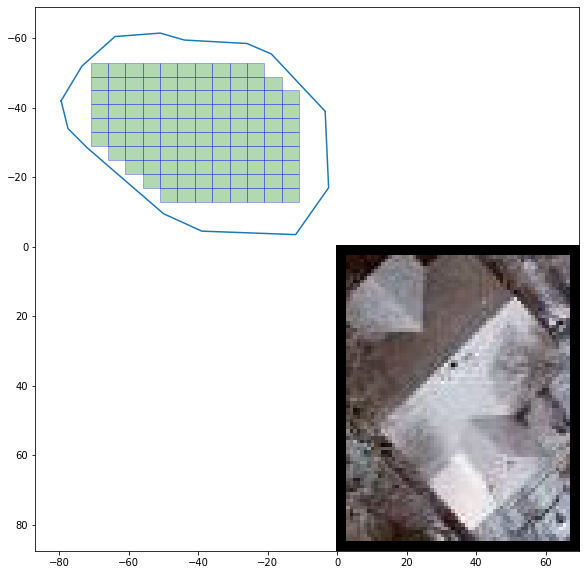

In [157]:
#@title Pinning the panels
# Functions to draw and plot our panels
def draw_panels(building_poly, dx, dy, pad):
    xmin, ymin, xmax, ymax = building_poly.bounds
    xs = np.arange(np.floor(xmin+pad), np.ceil(xmax-pad) + 1, dx) 
    ys = np.arange(np.floor(ymin+pad), np.ceil(ymax-pad) + 1, dy)

    rectangles = (Polygon([(x_start, y_start), (x_end, y_start), 
                       (x_end, y_end), (x_start, y_end)])
              for x_start, x_end in zip(xs, xs[1:])
              for y_start, y_end in zip(ys, ys[1:]))
   
    rectangles = [rectangle for rectangle in rectangles 
              if building_poly.contains(rectangle)]
    
    rectangles = MultiPolygon(rectangles)
    return rectangles


def plot_panels(building_poly, rectangles):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(building)
    #ax.set_aspect('equal', 'datalim')
    new_shape = rectangles
    #fig, axs = plt.subplots()
    ax.plot(*building_poly.exterior.xy)
    for geom in new_shape.geoms:    
        xs, ys = geom.exterior.xy    
        ax.fill(xs, ys, alpha=0.3, fc='g', ec='b')
    
    plt.show()  

def reflection(x0):
    return lambda x, y: (2*x0 - x, y)
##########################################
# Getting the polygon for our building

# get our polygon
building_poly = px_df.iloc[0].geometry
building_poly = scale(building_poly, yfact = -1, origin = (1, 0))
building_poly = transform(reflection(1), building_poly)

a = building_poly.minimum_rotated_rectangle

dim =input('Enter Panel in ft (width, heght)/ Default (5.4, 3.25) :') or "5.4, 3.25"
pad = int(input('Enter Padding (Default: 3) :') or "3") # Leave padding on the edges

px_dim = 0.974
dim = list(dim)
width = float(dim[0])
height = float(dim[-1])
(dx, dy) = (np.ceil(width * px_dim), np.floor(height * px_dim))
(dx, dy) 
rectangles = draw_panels(building_poly, dx, dy, pad)
print("Number of panels:", len(rectangles))
plot_panels(building_poly, rectangles)